<a href="https://colab.research.google.com/github/RaulMrSouza/Compra-Por-Volatilidade/blob/master/Compra_por_volatilidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import pandas as pd
import pandas_datareader.data as web
from datetime import date, timedelta
import numpy as np

In [58]:
dfs = {} 
stocks = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'PETR3.SA', 'ABEV3.SA']
for stock in stocks:
  df = web.DataReader(stock, 'yahoo', date.today() - timedelta(days=380), date.today())
  dfs[stock] = df
#for stock, df in dfs.items():
  #print(df.tail())

In [59]:
for stock, df in dfs.items():
  #Calculate Bollinger Bands Values
  df['20 Day MA'] = df['Close'].rolling(window=20).mean()
  df['20 Day STD'] = df['Close'].rolling(window=20).std() 

  df['Vol'] =  df['Close'].rolling(21).std(ddof=0)

  df['VolM'] = df['Close'].rolling(21).std(ddof=0).rolling(21).mean()
      
  df['Upper'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
  df['Lower'] = df['20 Day MA'] - (df['20 Day STD'] * 2)

  dfs[stock] = df

In [60]:
for stock, df in dfs.items():
  df = df[20:]
  #Set the buy and sell conditions
  df['B'] =  ((df['Vol'] <=  df['VolM']) & (df['Vol'].shift(periods=1) >  df['VolM'].shift(periods=1)) & (df['Close'] <  df['20 Day MA'])  )
  df = df.assign(Buy=np.where(df['B'] , df['Close'], float("NaN")))

  df['S'] =  ((df['Vol'] >=  df['VolM'])  & (df['Vol'].shift(periods=1) <  df['VolM'].shift(periods=1))  & (df['Close'] >  df['20 Day MA'])  )
  df = df.assign(Sell=np.where(df['S'] , df['Close'], float("NaN")))
  
  dfs[stock] = df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(15, 12))

Buy on the <font color='blue'>*Blue*</font> dot and stop operation on the <font color='red'>*Red*</font> dot, assuming markets usually are bullish

Comprar no ponto <font color='blue'>*Azul*</font> e sair da operação no <font color='red'>*Vermelho*</font>, considerando que mercados normalmente se valorizam

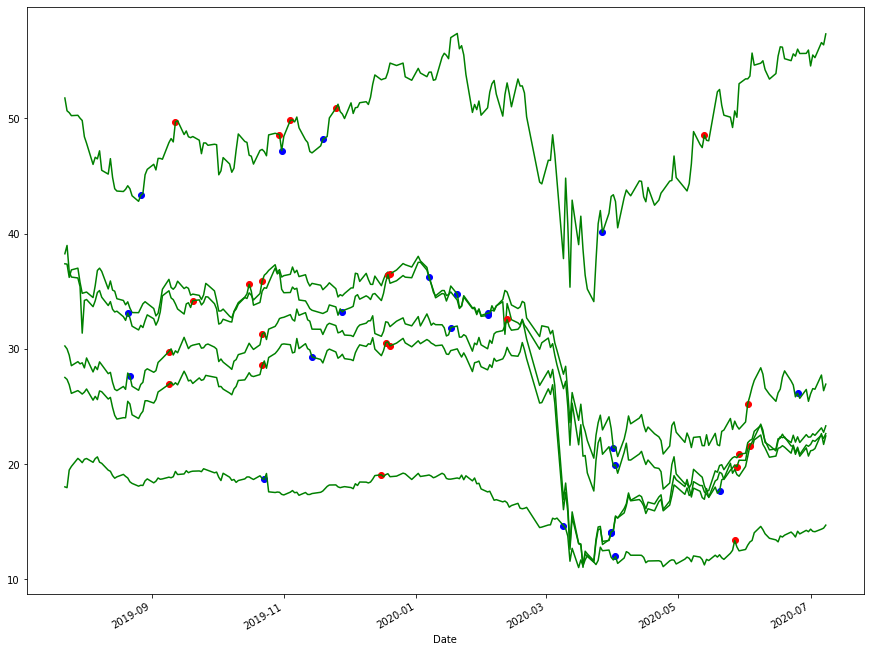

In [62]:
for stock, df in dfs.items():
  df['Buy'].plot(label='Buy', linestyle='--', marker='o', color='b')
  df['Sell'].plot(label='Sell', linestyle='--', marker='o', color='r')
  df['Close'].plot(label='Close', color='g')

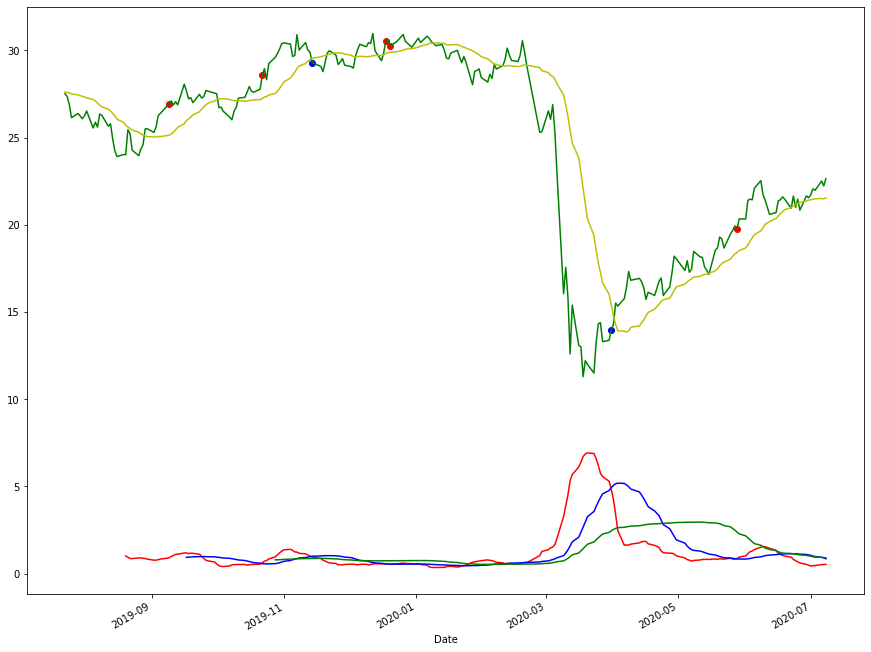

In [63]:
stockEx = "PETR4.SA"
dfs[stockEx]['Buy'].plot(label='Buy', linestyle='--', marker='o', color='b')
dfs[stockEx]['Sell'].plot(label='Sell', linestyle='--', marker='o', color='r')
dfs[stockEx]['Close'].plot(label='Close', color='g')
dfs[stockEx]['20 Day MA'].plot(label='Close', color='y')
dfs[stockEx]['Close'].rolling(21).std(ddof=0).plot(label='Close', color='r')
dfs[stockEx]['Close'].rolling(21).std(ddof=0).rolling(21).mean().plot(label='Close', color='b')
dfs[stockEx]['Close'].rolling(21).std(ddof=0).rolling(50).mean().plot(label='Close', color='g')

In [64]:
#set the operations result dataframe
results = {}
for stock, df in dfs.items():
  op = df[df['B'] | df['S']]
  op = op[op['B'] | op['B'].shift(periods=1)]
  op = pd.concat([op, df.tail(1)])
  op = op[op['B'] != op['B'].shift(periods=1)]
  op['Date'] = op.index
  op['BuyDate'] = op['Date'].shift(periods=1)
  op['BuyValue'] = op['Close'].shift(periods=1)
  op = op.assign(Result=np.where( op['B'] == False & op['B'].shift(periods=1), round(op['Close'] - op['Close'].shift(periods=1), 2), 0))
  op = op.rename(columns={'Date':'StopDate', 'Close' : 'StopValue'})
  op = op[op['B'] == False]
  op = op.assign(Gain=np.where(op['Result'] > 0 , 1, 0))
  op[['BuyValue', 'BuyDate', 'StopValue' , 'StopDate', 'Result']]
  results[stock] = op
results
valor = 0
for stock, df in results.items():
  valor += df['BuyValue'].iloc[0]*100
  #print(stock, " compra inicial R$: ", df['BuyValue'].iloc[0]*100, " data: ", df['BuyDate'].iloc[0])
  #print(df)
  
print(valor)

18824.999809265137


In [65]:
total = 0
gains = 0
totalOp = 0
for stock, df in results.items():
  total += df['Result'].sum()
  gains += df['Gain'].sum()
  totalOp += df.shape[0]
  print(stock, "%+5.2f" % (df['Result'].sum())," operacoes ", df.shape[0], ", com lucro", df['Gain'].sum())
print("Total R$","%3.2f" % (total), " por ação, cresc: ", round((total*100)/(valor/100.0), 2), "%", " operacoes ", totalOp, "com lucro", gains)

PETR4.SA +7.02  operacoes  2 , com lucro 2
VALE3.SA +20.12  operacoes  4 , com lucro 4
ITUB4.SA -10.17  operacoes  2 , com lucro 1
BBDC4.SA -8.86  operacoes  3 , com lucro 2
PETR3.SA +9.54  operacoes  3 , com lucro 3
ABEV3.SA -0.89  operacoes  2 , com lucro 1
Total R$ 16.76  por ação, cresc:  8.9 %  operacoes  16 com lucro 13
